# Word Embedding Translator

## Libraries

In [1]:
import numpy as np
import pandas as pd
import itertools as it
import openpyxl

from gensim.models import KeyedVectors

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

from IPython.display import Image, display

## 1 - Loading data
Loading the models and sentences used.
- Models: https://fasttext.cc/docs/en/crawl-vectors.html
- Sentences: https://github.com/alexa/massive

In [2]:
def load_files(model_path, sentences_path, limit = None):
    '''
    Load models from FastText folder and sentences from Amazon Massive folder.
    
    Params:
    - model_path: path to the folder containing all models used, i.e., FastText
    - sentences_path: path to the folder containing all sentences used, i.e., Amazon_Massive
    - limit: define a limit in case your have low computer power, e.g., 5000
    
    Return:
    Tuple containing the language model and its corresponding sentences
    '''

    model = KeyedVectors.load_word2vec_format(model_path, unicode_errors = 'replace', limit = limit)
    sentences = pd.read_json(sentences_path, lines = True)['utt']
    
    return model, sentences

Defining data path.

In [3]:
FASTTEXT_PATH = 'Datasets/FastText/'
MASSIVE_PATH = 'Datasets/Amazon_Massive/'

In [4]:
PATHS = {
    'en': [ FASTTEXT_PATH + 'cc.en.300.vec', MASSIVE_PATH + 'en-US.jsonl' ],
    'pt': [ FASTTEXT_PATH + 'cc.pt.300.vec', MASSIVE_PATH + 'pt-PT.jsonl' ],
    'es': [ FASTTEXT_PATH + 'cc.es.300.vec', MASSIVE_PATH + 'es-ES.jsonl' ],
    'fr': [ FASTTEXT_PATH + 'cc.fr.300.vec', MASSIVE_PATH + 'fr-FR.jsonl' ],
    'it': [ FASTTEXT_PATH + 'cc.it.300.vec', MASSIVE_PATH + 'it-IT.jsonl' ],
    'ro': [ FASTTEXT_PATH + 'cc.ro.300.vec', MASSIVE_PATH + 'ro-RO.jsonl' ],
    'de': [ FASTTEXT_PATH + 'cc.de.300.vec', MASSIVE_PATH + 'de-DE.jsonl' ],
    'da': [ FASTTEXT_PATH + 'cc.da.300.vec', MASSIVE_PATH + 'da-DK.jsonl' ],
    'nl': [ FASTTEXT_PATH + 'cc.nl.300.vec', MASSIVE_PATH + 'nl-NL.jsonl' ],
    'sv': [ FASTTEXT_PATH + 'cc.sv.300.vec', MASSIVE_PATH + 'sv-SE.jsonl' ],
}

LANGUAGES = PATHS.keys()

**Note**: the cell below takes approximately 5 to 6 minutes per model.

In [5]:
MODELS, SENTENCES = {}, {}

for language, value in PATHS.items():
    model = value[0]
    sentences = value[1]

    print("Loading", model)
    MODELS[language], SENTENCES[language] = load_files(model, sentences)
    print("Finished loading", model)

print("\nAll models and sentences are now loaded!")

Loading Datasets/FastText/cc.en.300.vec
Finished loading Datasets/FastText/cc.en.300.vec
Loading Datasets/FastText/cc.pt.300.vec
Finished loading Datasets/FastText/cc.pt.300.vec
Loading Datasets/FastText/cc.es.300.vec
Finished loading Datasets/FastText/cc.es.300.vec
Loading Datasets/FastText/cc.fr.300.vec
Finished loading Datasets/FastText/cc.fr.300.vec
Loading Datasets/FastText/cc.it.300.vec
Finished loading Datasets/FastText/cc.it.300.vec
Loading Datasets/FastText/cc.ro.300.vec
Finished loading Datasets/FastText/cc.ro.300.vec
Loading Datasets/FastText/cc.de.300.vec
Finished loading Datasets/FastText/cc.de.300.vec
Loading Datasets/FastText/cc.da.300.vec
Finished loading Datasets/FastText/cc.da.300.vec
Loading Datasets/FastText/cc.nl.300.vec
Finished loading Datasets/FastText/cc.nl.300.vec
Loading Datasets/FastText/cc.sv.300.vec
Finished loading Datasets/FastText/cc.sv.300.vec

All models and sentences are now loaded!


## 2 - Preparing data

In [6]:
SAMPLES = { key: [] for key in LANGUAGES }

In [7]:
# Since all sentence files have the same length, we chose one at random for the range function.
# We prove this in the cell below
for idx in range(len(SENTENCES['en'])):
    
    actual_sentence = { key: [] for key in LANGUAGES }
    
    try:
        for lang, sent in SENTENCES.items():
            for word in sent[idx].split(' '):
                actual_sentence[lang].append(MODELS[lang][word])

    except KeyError:
        continue
    
    for key, value in actual_sentence.items():
        SAMPLES[key].append([SENTENCES[key][idx], sum(value)])

In [8]:
for key in SENTENCES:
    SIZE_SAMPLES = len(SAMPLES[key])
    print(f'Total sentences in { key } file: { len(SENTENCES[key]) } -> Model { key } samples: { len(SAMPLES[key]) } ({ len(SAMPLES[key]) / len(SENTENCES[key]) * 100:.2f}%)')

Total sentences in en file: 16521 -> Model en samples: 7371 (44.62%)
Total sentences in pt file: 16521 -> Model pt samples: 7371 (44.62%)
Total sentences in es file: 16521 -> Model es samples: 7371 (44.62%)
Total sentences in fr file: 16521 -> Model fr samples: 7371 (44.62%)
Total sentences in it file: 16521 -> Model it samples: 7371 (44.62%)
Total sentences in ro file: 16521 -> Model ro samples: 7371 (44.62%)
Total sentences in de file: 16521 -> Model de samples: 7371 (44.62%)
Total sentences in da file: 16521 -> Model da samples: 7371 (44.62%)
Total sentences in nl file: 16521 -> Model nl samples: 7371 (44.62%)
Total sentences in sv file: 16521 -> Model sv samples: 7371 (44.62%)


Splitting into train and test.

In [9]:
SPLIT_RATE = int(SIZE_SAMPLES * 0.7)

TRAIN_SET = { key: SAMPLES[key][:SPLIT_RATE] for key in LANGUAGES }
TEST_SET = { key: SAMPLES[key][SPLIT_RATE:] for key in LANGUAGES }

## 3 - Translating words

In [10]:
TRANSLATIONS = { key: { lang: None for lang in LANGUAGES if lang != key } for key in LANGUAGES }

In [11]:
for origin, target in it.permutations(LANGUAGES, 2): 

    samples_origin = [sample[1] for sample in TRAIN_SET[origin]]
    samples_target = [sample[1] for sample in TRAIN_SET[target]]

    U, Sig, Vt = np.linalg.svd(np.transpose(samples_origin) @ samples_target)
    
    TRANSLATOR = np.transpose(Vt) @ np.transpose(U)
    TRANSLATIONS[origin][target] = TRANSLATOR

### List of examples words
**Note**: only single words can be written, i.e., compound words like "washing machine" will result in Error

- English

In [12]:
EN_WORD_LIST = [
    'specification',
    'book',
    'duckling',
    'machine',
    'headphones'
]

- Spanish

In [13]:
ES_WORD_LIST = [
    'hola',
    'sí',
    'computadora',
    'país'
]

- Portuguese

In [14]:
PT_WORD_LIST = [
    'sapato',
    'flor',
    'aniversário',
    'saudades',
]

In [15]:
def translate(word_list, origin_lang, target_lang):
    '''
    Function to translate one word from one language to another.

    Params:
    - word_list: list of example words.
    - origin_lang: language in which the words in word_list are written
    - target_lang: language you wish to know the translation

    Example of usage:
    translate(PT_WORD_LIST, 'es', 'pt')
    '''
    
    for word in word_list:
        print("Original word:", word)
        print("Top 10 most similar words in", target_lang)
        print(MODELS[target_lang].most_similar(TRANSLATIONS[origin_lang][target_lang] @ MODELS[origin_lang][word]))
        print("\n")

### Examples

- Portuguese -> Spanish

In [16]:
translate(PT_WORD_LIST, 'pt', 'es')

Original word: sapato
Top 10 most similar words in es
[('zapato', 0.5979515314102173), ('bolso', 0.5027395486831665), ('zapatos', 0.4995059370994568), ('sapato', 0.4886995553970337), ('zapatito', 0.4637773633003235), ('tacones', 0.46361279487609863), ('vestidito', 0.46291956305503845), ('vestido', 0.4623996913433075), ('abriguito', 0.4623886048793793), ('collarcito', 0.4617096185684204)]


Original word: flor
Top 10 most similar words in es
[('flor', 0.518313467502594), ('peonia', 0.4444171190261841), ('plantita', 0.43985143303871155), ('rosa', 0.4362567365169525), ('gardenia', 0.43582063913345337), ('hadita', 0.434613436460495), ('matita', 0.43432340025901794), ('macetita', 0.42778557538986206), ('amapola', 0.4275236427783966), ('florecilla', 0.42369580268859863)]


Original word: aniversário
Top 10 most similar words in es
[('cumpleaños', 0.661307156085968), ('cumpleaño', 0.599289059638977), ('cumpleños', 0.5646085739135742), ('aniversario', 0.5452031493186951), ('Cumpleaños', 0.5345

- Portuguese -> English

In [17]:
translate(PT_WORD_LIST, 'pt', 'en')

Original word: sapato
Top 10 most similar words in en
[('shoes', 0.4887855648994446), ('shoes.', 0.44583889842033386), ('shoes.It', 0.440299928188324), ('shoe', 0.4364120662212372), ('high-heels', 0.4322390854358673), ('wear', 0.4320979714393616), ('shoes.I', 0.4249747395515442), ('shoes.And', 0.4188053011894226), ('shoes.What', 0.4184603989124298), ('shoes.The', 0.4148173928260803)]


Original word: flor
Top 10 most similar words in en
[('flowers', 0.4574926495552063), ('peony', 0.45678797364234924), ('flower', 0.45566099882125854), ('flowers.So', 0.446369469165802), ('flowers.And', 0.44436922669410706), ('frangipani', 0.4429910480976105), ('hydrangea', 0.4408051371574402), ('lilac', 0.44008687138557434), ('floweres', 0.4364868700504303), ('flower.I', 0.43395060300827026)]


Original word: aniversário
Top 10 most similar words in en
[('birthday', 0.6021787524223328), ('anniversary', 0.524921178817749), ('half-birthday', 0.5231814384460449), ('birthdays', 0.5211805701255798), ('brithda

- Spanish -> English

In [18]:
translate(ES_WORD_LIST, 'es', 'en')

Original word: hola
Top 10 most similar words in en
[('hi', 0.7560582160949707), ('hello', 0.7342492341995239), ('Hello', 0.5875437259674072), ('hellow', 0.5869857668876648), ('Hey', 0.5829854011535645), ('hey', 0.5817070007324219), ('hello.', 0.5796104669570923), ('helllo', 0.5592946410179138), ('hiya', 0.5528284311294556), ('Hi', 0.550499677658081)]


Original word: sí
Top 10 most similar words in en
[('if', 0.5291672348976135), ('no', 0.5196767449378967), ('it', 0.51912522315979), ('is', 0.50682133436203), ('But', 0.4984217882156372), ('so', 0.4945758581161499), ('So', 0.4752298593521118), ('And', 0.47116318345069885), ('he', 0.47106507420539856), ('be', 0.46563899517059326)]


Original word: computadora
Top 10 most similar words in en
[('computer', 0.5365081429481506), ('computers', 0.5113204717636108), ('computer.But', 0.4441037178039551), ('lap-top', 0.4435492753982544), ('compuer', 0.4435286521911621), ('laptop', 0.4348880350589752), ('super-computer', 0.42963653802871704), ('co

- English -> Portuguese

In [19]:
translate(EN_WORD_LIST, 'en', 'pt')

Original word: specification
Top 10 most similar words in pt
[('especificação', 0.4426162540912628), ('defnição', 0.37427443265914917), ('certiﬁcação', 0.3630721867084503), ('modelo-base', 0.3566977083683014), ('especiﬁcação', 0.3435817062854767), ('ISA-95', 0.343571275472641), ('e-ping', 0.33819273114204407), ('formalizada', 0.33814647793769836), ('ECMA-335', 0.3362056314945221), ('comoreferência', 0.3345833420753479)]


Original word: book
Top 10 most similar words in pt
[('livro', 0.6571274399757385), ('livrinho', 0.5561516284942627), ('livroO', 0.5443723201751709), ('livros', 0.5368126034736633), ('olivro', 0.5267401337623596), ('livro.O', 0.5253267288208008), ('livo', 0.5119891166687012), ('livroA', 0.5110560655593872), ('umlivro', 0.5052586793899536), ('ler', 0.4994562864303589)]


Original word: duckling
Top 10 most similar words in pt
[('galinha', 0.3759934604167938), ('franguinho', 0.37412822246551514), ('maltine', 0.37038320302963257), ('codorniz', 0.3683798611164093), ('ovin

## 4 - Translating words using intermediate languages

### Getting the most similar word in each language it pass.
Most expensive (uses most_similar multiple times) and try to aproximate a word each time.

In [20]:
def intermediate_most_similar_word(word_list, origin_lang, intermediate_lang, target_lang):
    '''
    Translate one word from one language to another passing by an intermediate language.
    In this function, we use the result of the most similar word of the intermediate language to make the next translation.

    Params:
    - word_list: list of example words.
    - origin_lang: language in which the words in word_list are written
    - intermediate_lang: intermediate language which translation between origin_lang and target_lang passes by
    - target_lang: language you wish to know the translation

    Example of usage:
    intermediate_most_similar_word(PT_WORD_LIST, 'es', 'pt', 'en')
    '''
    
    for word in word_list:
        print("Original word:", word)
        
        intermediate_word = MODELS[intermediate_lang].most_similar(TRANSLATIONS[origin_lang][intermediate_lang] @ MODELS[origin_lang][word])[0][0]
        print("Most similar word according to intermediate language:", intermediate_word)

        translated_language = MODELS[target_lang].most_similar(TRANSLATIONS[intermediate_lang][target_lang] @ MODELS[intermediate_lang][intermediate_word])
        print("Top 10 most similar words in target language passing by the intermediate language:")
        print(translated_language)
        
        print("\n")

- Portuguese -> English -> Spanish

In [21]:
intermediate_most_similar_word(PT_WORD_LIST, 'pt', 'en', 'es')

Original word: sapato
Most similar word according to intermediate language: shoes
Top 10 most similar words in target language passing by the intermediate language:
[('zapatos', 0.6263899803161621), ('sandalias', 0.5752242207527161), ('zapatillas', 0.5647622346878052), ('calzado', 0.535328209400177), ('botas', 0.5285427570343018), ('zapato', 0.5056540369987488), ('calcetines', 0.5011087656021118), ('chanclas', 0.499675452709198), ('calzados', 0.4985480308532715), ('tacones', 0.498035728931427)]


Original word: flor
Most similar word according to intermediate language: flowers
Top 10 most similar words in target language passing by the intermediate language:
[('flores', 0.5934178233146667), ('rosas', 0.5280625224113464), ('flor', 0.4900701344013214), ('peonías', 0.47081130743026733), ('pétalos', 0.46510791778564453), ('florales', 0.4464442729949951), ('peonias', 0.4431328773498535), ('florecitas', 0.4396395981311798), ('rosa', 0.4395676851272583), ('hortensias', 0.43930017948150635)]



- Spanish -> Portuguese -> English

In [22]:
intermediate_most_similar_word(ES_WORD_LIST, 'es', 'pt', 'en')

Original word: hola
Most similar word according to intermediate language: olá
Top 10 most similar words in target language passing by the intermediate language:
[('hello', 0.742811918258667), ('hi', 0.7183173894882202), ('hey', 0.6434046030044556), ('hellow', 0.6133357286453247), ('helllo', 0.6021028757095337), ('Hey', 0.5923214554786682), ('hello.', 0.581925094127655), ('hello-', 0.5704084038734436), ('Hello', 0.5677409172058105), ('hullo', 0.545852541923523)]


Original word: sí
Most similar word according to intermediate language: só
Top 10 most similar words in target language passing by the intermediate language:
[('if', 0.5996302366256714), ('is', 0.5058877468109131), ('it', 0.4969756603240967), ('me', 0.49583423137664795), ('But', 0.48715007305145264), ('but', 0.46752163767814636), ('ok', 0.46380290389060974), ('so', 0.4605371654033661), ('I', 0.4595421552658081), ('then', 0.458884596824646)]


Original word: computadora
Most similar word according to intermediate language: comp

- English -> Spanish -> Portuguese

In [23]:
intermediate_most_similar_word(EN_WORD_LIST, 'en', 'es', 'pt')

Original word: specification
Most similar word according to intermediate language: especificación
Top 10 most similar words in target language passing by the intermediate language:
[('especificação', 0.5770426988601685), ('descrição', 0.48494386672973633), ('exaustividade', 0.480832040309906), ('defnição', 0.46489545702934265), ('especificada', 0.4457739293575287), ('especicação', 0.44558510184288025), ('definição', 0.4376484751701355), ('especifica-se', 0.43385618925094604), ('especíca', 0.4337528645992279), ('detalhada', 0.43155232071876526)]


Original word: book
Most similar word according to intermediate language: libro
Top 10 most similar words in target language passing by the intermediate language:
[('livro', 0.8113560676574707), ('livrinho', 0.6657062768936157), ('livro.O', 0.6563439965248108), ('livroO', 0.6342556476593018), ('olivro', 0.6276281476020813), ('livro.E', 0.6218340992927551), ('umlivro', 0.6172230839729309), ('livro.Este', 0.6154317259788513), ('livro.É', 0.61538

### Using the vector transformed to each subspace.
Uses most_similar and try to approximate the word just one time.

In [24]:
def intermediate_most_similar_vector(word_list, origin_lang, intermediate_lang, target_lang):
    '''
    Translate one word from one language to another passing by an intermediate language.
    In this function, we use the result of the vector of the translation passing by the intermediate language to make the next translation.

    Params:
    - word_list: list of example words.
    - origin_lang: language in which the words in word_list are written
    - intermediate_lang: intermediate language which translation between origin_lang and target_lang passes by
    - target_lang: language you wish to know the translation

    Example of usage:
    intermediate_most_similar_vector(PT_WORD_LIST, 'es', 'pt', 'en')
    '''
    
    for word in word_list:
        print("Original word:", word)

        intermediate_vector = TRANSLATIONS[origin_lang][intermediate_lang] @ MODELS[origin_lang][word]
        translated_vector = MODELS[target_lang].most_similar(TRANSLATIONS[intermediate_lang][target_lang] @ intermediate_vector)
        
        print("Top 10 most similar words in target language passing by the intermediate language:")
        print(translated_vector)
        print("\n")

- Portuguese -> English -> Spanish

In [25]:
intermediate_most_similar_vector(PT_WORD_LIST, 'pt', 'en', 'es')

Original word: sapato
Top 10 most similar words in target language passing by the intermediate language:
[('zapato', 0.4852682948112488), ('abriguito', 0.48036426305770874), ('abrigo', 0.4550402760505676), ('zapatos', 0.44505050778388977), ('bolso', 0.4423503279685974), ('vestido', 0.43324363231658936), ('calzado', 0.4223168194293976), ('atuendo', 0.4210219979286194), ('mocasin', 0.4204149544239044), ('pantalon', 0.42025434970855713)]


Original word: flor
Top 10 most similar words in target language passing by the intermediate language:
[('flor', 0.5238182544708252), ('peonia', 0.45686599612236023), ('rosa', 0.4424068331718445), ('rosaY', 0.4367314279079437), ('florecilla', 0.4352421462535858), ('rosaa', 0.4348652958869934), ('peonía', 0.4337921440601349), ('rosay', 0.42707061767578125), ('rosa.La', 0.4266868531703949), ('azalea', 0.4165915250778198)]


Original word: aniversário
Top 10 most similar words in target language passing by the intermediate language:
[('cumpleaños', 0.62011

- Spanish -> Portuguese -> English

In [26]:
intermediate_most_similar_vector(ES_WORD_LIST, 'es', 'pt', 'en')

Original word: hola
Top 10 most similar words in target language passing by the intermediate language:
[('hello', 0.6747809052467346), ('hi', 0.6701148748397827), ('hey', 0.6180011630058289), ('Hey', 0.5616871118545532), ('helllo', 0.5605097413063049), ('hellow', 0.5472829937934875), ('Hello', 0.5435895323753357), ('hello.', 0.5293959975242615), ('heyyy', 0.5248358249664307), ('hellooooo', 0.5165208578109741)]


Original word: sí
Top 10 most similar words in target language passing by the intermediate language:
[('if', 0.529298722743988), ('is', 0.49316665530204773), ('But', 0.47112709283828735), ('it', 0.4664361774921417), ('but', 0.46566009521484375), ('And', 0.44414767622947693), ('so', 0.44141972064971924), ('ok', 0.44055530428886414), ('correct.But', 0.43578124046325684), ('So', 0.4329026937484741)]


Original word: computadora
Top 10 most similar words in target language passing by the intermediate language:
[('computer', 0.4913015365600586), ('computers', 0.44491007924079895), (

- English -> Spanish -> Portuguese

In [27]:
intermediate_most_similar_vector(EN_WORD_LIST, 'en', 'es', 'pt')

Original word: specification
Top 10 most similar words in target language passing by the intermediate language:
[('especificação', 0.41693899035453796), ('formulário-padrão', 0.36281949281692505), ('defnição', 0.3521471619606018), ('equivalência', 0.3481849730014801), ('justificase', 0.34663113951683044), ('conformidade', 0.3437771797180176), ('modelo-padrão', 0.3421115279197693), ('CERTICS', 0.3400566875934601), ('certiﬁcação', 0.33947134017944336), ('pauta-se', 0.338617742061615)]


Original word: book
Top 10 most similar words in target language passing by the intermediate language:
[('livro', 0.6437900066375732), ('livroA', 0.5496819615364075), ('livroO', 0.5448164939880371), ('livro.O', 0.5299033522605896), ('umlivro', 0.526361346244812), ('livrinho', 0.522763729095459), ('leitura', 0.5122231841087341), ('livros', 0.5119393467903137), ('livrode', 0.5046753883361816), ('olivro', 0.5027450919151306)]


Original word: duckling
Top 10 most similar words in target language passing by t

## 5 - Evaluating

Theorically speaking, translating the vector that one sentence represents to another should result in a similar sentence. For that purpose, we evaluate our results using the cosine similarity, which range is from -1 to 1.

In [28]:
def evaluate_single_cosine_similarity(origin_lang, target_lang):
    '''
    Evaluate cosine similarity between single sentences.
    Cosine similarity has an interval from -1 to 1, and the closer to 1 the value is, more similar the params are.

    Params:
    - origin_lang: language in which the words in word_list are written
    - target_lang: language you wish to know the translation

    Example of usage:
    evaluate_single_cosine_similarity('pt', 'en')
    '''
    
    for index in range(5):
        print(TEST_SET[origin_lang][index][0], '->', TEST_SET[target_lang][index][0])

        vector_translated = TRANSLATIONS[origin_lang][target_lang] @ TEST_SET[origin_lang][index][1]
        vector_target = TEST_SET[target_lang][index][1]

        print("Cossine similarity:", cosine_similarity([vector_translated], [vector_target])[0][0], "\n")

- Portuguese -> English

In [29]:
evaluate_single_cosine_similarity('pt', 'en')

recomenda um restaurante com preços médios -> recommend a restaurant with medium expense
Cossine similarity: 0.7970548 

recomenda um evento de rancho folclórico na área do grande porto esta semana -> recommend a blue grass band event within twenty miles of manchester ma this week
Cossine similarity: 0.8172929 

que eventos há a acontecer no porto -> what events are going on in new york city
Cossine similarity: 0.80422217 

que filmes estão em exibição neste momento -> what movies are playing right now
Cossine similarity: 0.6743865 

o que sugeres que eu veja este fim de semana -> what do you suggest that i watch this weekend
Cossine similarity: 0.88288456 



- Portuguese -> Spanish

In [30]:
evaluate_single_cosine_similarity('pt', 'es')

recomenda um restaurante com preços médios -> recomendar un restaurante con gasto medio
Cossine similarity: 0.87046856 

recomenda um evento de rancho folclórico na área do grande porto esta semana -> recomendar un evento de blue grass banda dentro de veinte millas de manchester esta semana
Cossine similarity: 0.8474541 

que eventos há a acontecer no porto -> qué eventos se celebran en la ciudad de nueva york
Cossine similarity: 0.7752107 

que filmes estão em exibição neste momento -> qué películas dan ahora
Cossine similarity: 0.5479336 

o que sugeres que eu veja este fim de semana -> qué sugieres que vea este fin de semana
Cossine similarity: 0.8268164 



- English -> Spanish

In [31]:
evaluate_single_cosine_similarity('en', 'es')

recommend a restaurant with medium expense -> recomendar un restaurante con gasto medio
Cossine similarity: 0.86160165 

recommend a blue grass band event within twenty miles of manchester ma this week -> recomendar un evento de blue grass banda dentro de veinte millas de manchester esta semana
Cossine similarity: 0.87208486 

what events are going on in new york city -> qué eventos se celebran en la ciudad de nueva york
Cossine similarity: 0.8317412 

what movies are playing right now -> qué películas dan ahora
Cossine similarity: 0.7508562 

what do you suggest that i watch this weekend -> qué sugieres que vea este fin de semana
Cossine similarity: 0.8020289 



### Avaliating path
We use the following metrics for that purpose:
- Cosine similarity
- Euclidean distance
- Manhattan distance

In [32]:
def pairwise(iterable):
    '''
    Return successive overlapping pairs taken from the input iterable.
    The number of 2-tuples in the output iterator will be one fewer than the number of inputs. 
    It will be empty if the input iterable has fewer than two values.
    pairwise('ABCDEFG') --> AB BC CD DE EF FG

    Source: https://docs.python.org/3/library/itertools.html#itertools.pairwise
    '''
    a, b = it.tee(iterable)
    next(b, None)
    return zip(a, b)

In [42]:
def avaliate_path(path):
    '''
    Avaliate the translation path using cosine similarity, euclidean distance and manhattan distance.

    Params:
    - path: path of desired translation
    
    Return:
    - Score of each avaliation method
    
    Example of usage:
    avaliate_path(['pt', 'en', 'es'])
    '''
    
    #return (1, 1, 1) #using for test only
    translation_matrix = np.identity(300)

    for (origin, target) in pairwise(path):
        translation_matrix = TRANSLATIONS[origin][target] @ translation_matrix
    
    vectors = [translation_matrix @ v for _, v in TEST_SET[path[0]] ]
    vectors_target = [v for _, v in TEST_SET[path[-1]]]
    
    mean_cos_sim = sum([cosine_similarity([v1], [v2]) for v1, v2 in zip(vectors, vectors_target)])/ len(vectors)
    mean_euc_dist = sum([euclidean_distances([v1], [v2]) for v1, v2 in zip(vectors, vectors_target)])/ len(vectors)
    mean_man_dist = sum([manhattan_distances([v1], [v2]) for v1, v2 in zip(vectors, vectors_target)])/ len(vectors)
    
    return mean_cos_sim[0][0], mean_euc_dist[0][0], mean_man_dist[0][0]

In [43]:
def avaliate_possible_paths(languages):
    '''
    Avaliate possible paths from first to last language on the list, changing the languages in the middle
    
    Params:
    - languages: list of languages
    
    Return:
    - Dataframe with the score of each path on cossine similarity, euclidean distance and manhattan distance
    
    Example of usage:
    avaliate_paths(['pt', 'en', 'es'])
    '''
    
    start = languages[0]
    end = languages[-1]
    
    paths = [[start, end]]
    for i in range(len(languages) -2 ):
        for comb in it.combinations(languages[1:-1], i+1):
            paths.append([start] + list(comb) + [end])
    
    scores = [avaliate_path(p) for p in paths]
    index = [ ' -> '.join(p) for p in paths]
    return pd.DataFrame(data=scores, columns=['Cosine Similarity', 'Euclidean Distance', 'Manhattan Distance'], index=index)


## 6 - Experiments

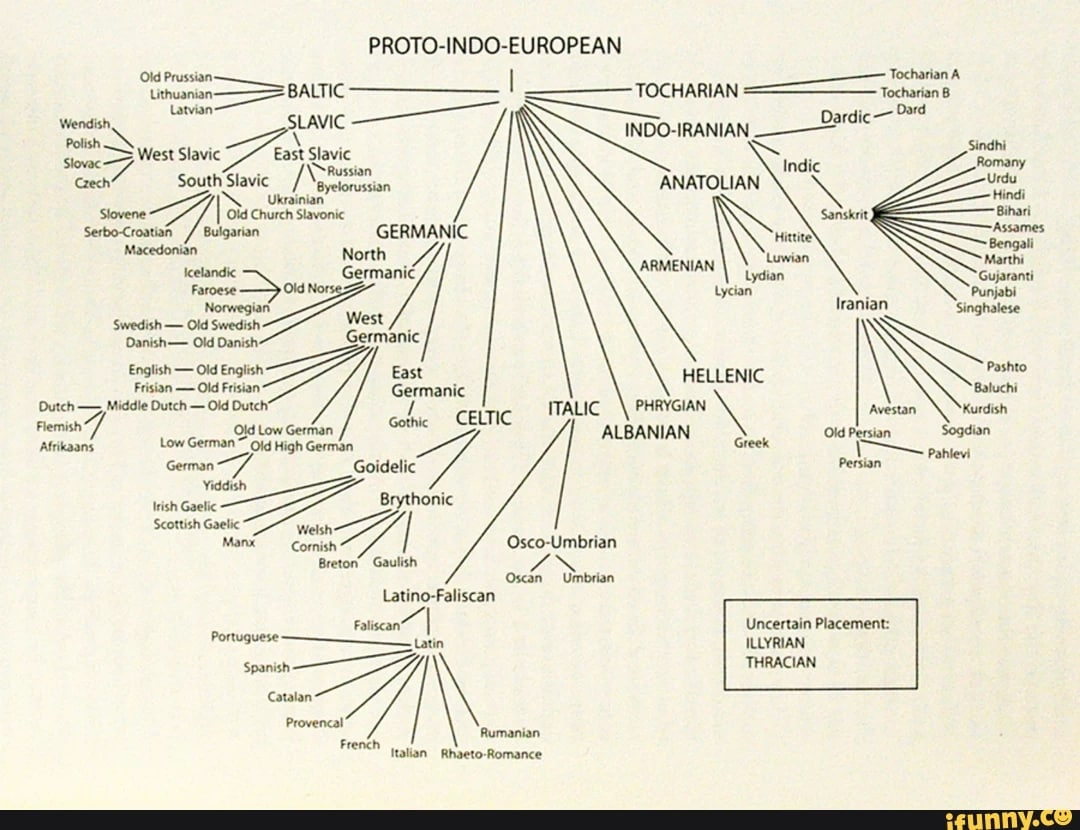

In [44]:
display(Image(filename = 'Images/proto-indo-european.jpg'))

### Experiment #1: Portuguese - English - Spanish
In this experiment, we intend to evaluate how good is a translation between two languages from the Latin group, such as Portuguese and Spanish, and if adding a language from an outer group, such as English from the West Germanic, affects the quality of the translation.

In [45]:
exp1 = avaliate_possible_paths(['pt', 'en', 'es'])
exp1

,Cosine Similarity,Euclidean Distance,Manhattan Distance
pt -> es,0.750518,3.95444,49.712066
pt -> en -> es,0.722473,4.17853,54.014994


### Experiment #2: Portuguese - Spanish - French - Italian - Romanian
In this experiment, we intend to evaluate translations between multiple languages from the same Latin group.

In [47]:
df = avaliate_possible_paths(['pt', 'fr', 'it', 'ro', 'es'])
df

,Cosine Similarity,Euclidean Distance,Manhattan Distance
pt -> es,0.750518,3.954440,49.712066
pt -> fr -> es,0.734747,4.065414,51.722281
pt -> it -> es,0.736420,4.045300,51.279482
pt -> ro -> es,0.723913,4.162426,53.563510
pt -> fr -> it -> es,0.724742,4.128758,52.802810
pt -> fr -> ro -> es,0.713453,4.216944,54.353191
pt -> it -> ro -> es,0.715252,4.208782,54.251189
pt -> fr -> it -> ro -> es,0.705802,4.269050,55.161047


> Adding a test with English in the middle

In [48]:
path = ['pt', 'fr', 'it', 'en', 'ro', 'es']
df2 = pd.DataFrame(data=[avaliate_path(path)], index=[' -> '.join(path)], columns=df.columns)
exp2 = pd.concat([df, df2])
exp2

,Cosine Similarity,Euclidean Distance,Manhattan Distance
pt -> es,0.750518,3.954440,49.712066
pt -> fr -> es,0.734747,4.065414,51.722281
pt -> it -> es,0.736420,4.045300,51.279482
pt -> ro -> es,0.723913,4.162426,53.563510
pt -> fr -> it -> es,0.724742,4.128758,52.802810
pt -> fr -> ro -> es,0.713453,4.216944,54.353191
pt -> it -> ro -> es,0.715252,4.208782,54.251189
pt -> fr -> it -> ro -> es,0.705802,4.269050,55.161047
pt -> fr -> it -> en -> ro -> es,0.692582,4.369908,56.852263


### Experiment #3: English - German - Swedish - Dutch - Danish
In this experiment, we intend to evaluate translations between multiple languages from the same Germanic group.

In [50]:
df = avaliate_possible_paths(['en', 'sv', 'nl', 'da', 'de'])
df

,Cosine Similarity,Euclidean Distance,Manhattan Distance
en -> de,0.738375,4.653678,60.131162
en -> sv -> de,0.726242,4.735488,61.697789
en -> nl -> de,0.732226,4.694412,60.995399
en -> da -> de,0.726201,4.738022,61.567906
en -> sv -> nl -> de,0.723059,4.754768,62.061841
en -> sv -> da -> de,0.717751,4.790199,62.525221
en -> nl -> da -> de,0.720725,4.770221,62.112542
en -> sv -> nl -> da -> de,0.713518,4.816309,62.979380


> Adding a test with Italian in the middle

In [51]:
path = ['en', 'sv', 'it', 'nl', 'da', 'de']
df2 = pd.DataFrame(data=[avaliate_path(path)], index=[' -> '.join(path)], columns=df.columns)
exp3 = pd.concat([df, df2])
exp3

,Cosine Similarity,Euclidean Distance,Manhattan Distance
en -> de,0.738375,4.653678,60.131162
en -> sv -> de,0.726242,4.735488,61.697789
en -> nl -> de,0.732226,4.694412,60.995399
en -> da -> de,0.726201,4.738022,61.567906
en -> sv -> nl -> de,0.723059,4.754768,62.061841
en -> sv -> da -> de,0.717751,4.790199,62.525221
en -> nl -> da -> de,0.720725,4.770221,62.112542
en -> sv -> nl -> da -> de,0.713518,4.816309,62.979380
en -> sv -> it -> nl -> da -> de,0.701176,4.896321,64.240493


### Experiment #4: Portuguese - German - French - English - Spanish
In this experiment, we intend to evaluate translations using languages from different groups.

In [52]:
exp4 = avaliate_possible_paths(['pt', 'de', 'fr', 'en', 'es'])
exp4

,Cosine Similarity,Euclidean Distance,Manhattan Distance
pt -> es,0.750518,3.954440,49.712066
pt -> de -> es,0.713967,4.244940,54.845612
pt -> fr -> es,0.734747,4.065414,51.722281
pt -> en -> es,0.722473,4.178530,54.014994
pt -> de -> fr -> es,0.706975,4.279639,55.455886
pt -> de -> en -> es,0.696251,4.373202,56.851846
pt -> fr -> en -> es,0.710485,4.250461,55.019113
pt -> de -> fr -> en -> es,0.697495,4.351858,56.566278


### Experiment #5: English - Spanish - Swedish - Italian - German
In this experiment, we intend to evaluate translations using languages from different groups.

In [53]:
exp5 = avaliate_possible_paths(['en', 'es', 'sv', 'it', 'de'])
exp5

,Cosine Similarity,Euclidean Distance,Manhattan Distance
en -> de,0.738375,4.653678,60.131162
en -> es -> de,0.725193,4.752190,61.762966
en -> sv -> de,0.726242,4.735488,61.697789
en -> it -> de,0.722264,4.764453,62.318824
en -> es -> sv -> de,0.716135,4.808971,62.876090
en -> es -> it -> de,0.710833,4.847731,63.563829
en -> sv -> it -> de,0.713004,4.815400,63.057167
en -> es -> sv -> it -> de,0.707707,4.855580,63.686974


### Saving results to spreadsheet

In [54]:
path = 'results.xlsx'
with pd.ExcelWriter(path) as writer:
    #writer.book = openpyxl.load_workbook(path)
    exp1.to_excel(writer, sheet_name='Experiment 1')
    exp2.to_excel(writer, sheet_name='Experiment 2')
    exp3.to_excel(writer, sheet_name='Experiment 3')
    exp4.to_excel(writer, sheet_name='Experiment 4')
    exp5.to_excel(writer, sheet_name='Experiment 5')